In [3]:
import ee
import numpy as np
import matplotlib.pyplot as plt
import shapefile as sf
import pandas as pd

In [4]:
ee.Authenticate()

True

In [5]:
#ee.Authenticate(force=True)
#ee.Authenticate()
#ee.Initialize(project = 'ee-fortschthomas52')
#ee.Initialize(project = 'ee-davidmkahler-limpopo')
ee.Initialize(project = 'sediment-473319')

## Determine Area of Interest

In [18]:
# Mamba, KNP
site = "Mamba"
sf = shapefile.Reader("/Volumes/dmk/gis/limpopo/kruger/logger_sites/reference_polygons/mamba/mamba.shp")

In [25]:
# Balule, KNP
site = "Balule"
sf = shapefile.Reader("/Users/rachelelavagno/Documents/kruger/reference_polygons/balule/balule.shp")

In [24]:
# Paul Kruger Gate, KNP
site = "Kruger Gate"
sf = shapefile.Reader("/Volumes/dmk/gis/limpopo/kruger/logger_sites/reference_polygons/kruger_gate/kruger_gate.shp")

In [ ]:
# Lower Sabie, KNP
site = "Lower Sabie"
sf = shapefile.Reader("/Volumes/dmk/gis/limpopo/kruger/logger_sites/reference_polygons/lower_sabie/lower_sabie.shp")

In [6]:
# Hanover, VA, USA
sf = shapefile.Reader("/Volumes/dmk/gis/limpopo/kruger/logger_sites/reference_polygons/virginia/hanover.shp")

In [26]:
shapes = sf.shapes()
points = shapes[0].points
aoi = ee.Geometry.Polygon(points)

UnboundLocalError: cannot access local variable 'mbox' where it is not associated with a value

In [6]:
aoi=ee.Geometry.Rectangle([31.71630970,-24.05487960,31.72086902,-24.05871824])

## Debug Code
This code works one step at a time and produces an RGB image.

In [7]:
startDate = "2023-10-10"
endDate = "2023-10-11"

In [8]:
# Pull image
image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
        .filterDate(startDate, endDate)\
        .select('B2', 'B3', 'B4', 'B8', 'B11')
         #.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)\
mosaic = image.median().reproject(crs='EPSG:32736', scale=10) # This allows us to set the resolution.
band_arrs = mosaic.sampleRectangle(region=aoi, defaultValue = 0)

### Determine Dates of Acquisition
Check out the [GEE Code Editor](https://code.earthengine.google.com/2bc6d0b39051c230c556370381c32c6f?noload=true) to determine the date of acquisition.

In [9]:
# Get individual band arrays.
band_arr_b2 = band_arrs.get('B2')   # Blue
band_arr_b3 = band_arrs.get('B3')   # Green
band_arr_b4 = band_arrs.get('B4')   # Red
band_arr_b8 = band_arrs.get('B8')   # NIR
band_arr_b11 = band_arrs.get('B11') # SWIR
# Transfer the arrays from server to client and cast as np array.
b2 = np.array(band_arr_b2.getInfo())   # b2  Blue
b3 = np.array(band_arr_b3.getInfo())   # b3  Green
b4 = np.array(band_arr_b4.getInfo())   # b4  Red
b8 = np.array(band_arr_b8.getInfo())   # b8  NIR
b11 = np.array(band_arr_b11.getInfo()) # b11 SWIR

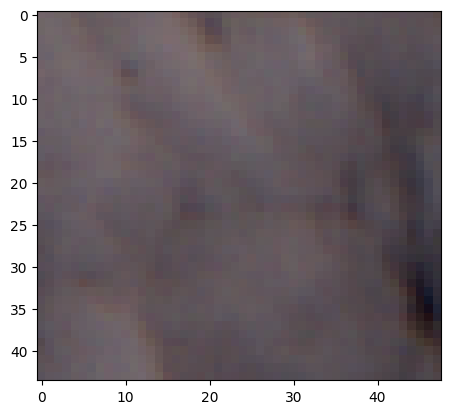

In [10]:
# Export RGB
np_arr_b4 = np.expand_dims(b4, 2)
np_arr_b3 = np.expand_dims(b3, 2)
np_arr_b2 = np.expand_dims(b2, 2)
rgb_img = np.concatenate((np_arr_b4, np_arr_b3, np_arr_b2), 2)
rgb_img = (255*((rgb_img)/3000)).astype('uint8')
plt.imshow(rgb_img)
plt.show()

## Run
This code runs the fuction over the date range.  Sentinel-2 flew over 2023-10-10, which appears to be the last day of the range; this is critical to determine the correlating *in situ* measurement.

In [26]:
start = pd.date_range(start= '2017-08-08' , end='2024-06-22' , 
              freq='5d')
end = pd.date_range(start='2017-08-13' , end='2024-06-27' , 
              freq='5d')
dates = pd.DataFrame ({'start': start ,  'end': end})
#print(dates)

In [27]:
# Define function
def pulldata(startDate, endDate):
    # Define source data
    image = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
        .filterDate(startDate, endDate)\
        .select('B2', 'B3', 'B4', 'B8', 'B11')
         #.filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)\
    
    # CRS is not the same.
    # proj = image.first().select('B2').projection() # EPSG:32656, UTM zone 56N (Siberia?)
    # proj = balule.projection() # EPSG:4326

    # Export arrays
    # https://gist.github.com/jdbcode/f4d56d72f7fc5beeaa3859999b1f5c3d
    # https://gist.github.com/jdbcode/f4d56d72f7fc5beeaa3859999b1f5c3d?permalink_comment_id=3355627#gistcomment-3355627
    mosaic = image.median().reproject(crs='EPSG:32736', scale=10) # This allows us to set the resolution.
    band_arrs = mosaic.sampleRectangle(region=aoi, defaultValue = 0)
    
    # Get individual band arrays.
    band_arr_b2 = band_arrs.get('B2')   # Blue
    band_arr_b3 = band_arrs.get('B3')   # Green
    band_arr_b4 = band_arrs.get('B4')   # Red
    band_arr_b5 = band_arrs.get('B5')   # Red edge
    band_arr_b8 = band_arrs.get('B8')   # NIR
    band_arr_b11 = band_arrs.get('B11') # SWIR

    # Transfer the arrays from server to client and cast as np array.
    b2 = np.array(band_arr_b2.getInfo())   # b2  Blue
    b3 = np.array(band_arr_b3.getInfo())   # b3  Green
    b4 = np.array(band_arr_b4.getInfo())   # b4  Red
    b5 = np.array(band_arr_b5.getInfo())   # b4  Red edge
    b8 = np.array(band_arr_b8.getInfo())   # b8  NIR
    b11 = np.array(band_arr_b11.getInfo()) # b11 SWIR
    if(np.max(b2)!=0):
        # Normalized Difference Water Index (NDWI)
        # NDWI = ( G - NIR ) / ( G + NIR )
        ndwiG = (b3-b8)/(b3+b8) # Gao
        # NDWI = ( NIR - SWIR ) / ( NIR + SWIR )
        ndwiM = (b8-b11)/(b8+b11) # McFeeters
        # NDWI = ( G - SWIR ) / ( G + SWIR )
        mndwi = (b3-b11)/(b3+b11) # Modified NDWI
        water = ndwiG > -0.02

        TSS1 = np.NAN
        Secchi1 = np.NAN
        TSS2 = np.NAN
        Secchi2 = np.NAN
        TSS3 = np.NAN
        Secchi3 = np.NAN
        TSS4 = np.NAN
        Ratio = np.NAN

        TSS1 = (b3+b4)/2
        TSS1 = TSS1 * water
        TSS1 = np.sum(TSS1) / np.sum(TSS1>0)

        Secchi1 = (b2/b4)
        Secchi1 = Secchi1 * water
        Secchi1 = np.sum(Secchi1)/ np.sum(Secchi1>0)

        TSS2 = (b3/b4)
        TSS2 = TSS2 * water
        TSS2 = np.sum(TSS2) / np.sum(TSS2>0)

        Secchi2 = (b4/b3)
        Secchi2 = Secchi2 * water
        Secchi2 = np.sum(Secchi2)/ np.sum(Secchi2>0)

        TSS3 = (b8/b3 , b8/b4)
        TSS3 = TSS3 * water
        TSS3 = np.sum(TSS3) / np.sum(TSS3>0)

        Secchi3 = (b4/b2)+b2
        Secchi3 = Secchi3 * water
        Secchi3 = np.sum(Secchi3)/ np.sum(Secchi3>0)

        TSS4 = (b4/b3)+b8
        TSS4 = TSS4 * water
        TSS4 = np.sum(TSS4) / np.sum(TSS4>0)

        Ratio = (ndwiG/ndwiM)
        Ratio = Ratio * water
        Ratio = np.sum(Ratio)/ np.sum(Ratio>0) 


        f = open("sentinel.csv", "a")
        f.write(str(site) + ", " + str(startDate) + ", " + str(endDate) + ", " + 
                str(TSS1) + ", " + str(Secchi1) + ", " + 
                str(TSS2) + ", " + str(Secchi2) + ", " + 
                str(TSS3) + ", " + str(Secchi3) + ", " + 
                str(TSS4) + "," + str(Ratio) + '\n') 
            
        f.close()

In [28]:
# Run over all dates
for i in range(len(dates)):
    pulldata(dates["start"][i], dates["end"][i])

/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:55: RuntimeWarning: invalid value encountered in scalar divide
  TSS1 = np.sum(TSS1) / np.sum(TSS1>0)
/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:59: RuntimeWarning: invalid value encountered in scalar divide
  Secchi1 = np.sum(Secchi1)/ np.sum(Secchi1>0)
/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:63: RuntimeWarning: invalid value encountered in scalar divide
  TSS2 = np.sum(TSS2) / np.sum(TSS2>0)
/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:67: RuntimeWarning: invalid value encountered in scalar divide
  Secchi2 = np.sum(Secchi2)/ np.sum(Secchi2>0)
/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:71: RuntimeWarning: invalid value encountered in scalar divide
  TSS3 = np.sum(TSS3) / np.sum(TSS3>0)
/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:

In [21]:
pulldata(startDate, endDate)

/var/folders/3m/3_cnzbmx5r72vkz_1lrm0pyh0000gn/T/ipykernel_11409/1592690793.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  Ratio = np.sum(Ratio)/ np.sum(Ratio>0)
